# Прототип модели поиска токсичных комментариев для интернет-магазина "Викишоп".

Задача - построить модель со значением метрики качества F1 не меньше 0,75.

______

#### Данное исследование разделим на несколько частей.
______________________
### Часть 1: Подготовка данных
* [1. Загрузка библиотек, загрузка данных и получение общей информации.](#1-bullet)
* [2. Предобработка данных: лемматизация и очистка текста.](#2-bullet)
* [3. Разделение данных на обучающую, валидационную и тестовую выборки, выделение целевого признака.](#3-bullet)
* [4. Векторизация текста, удаление стоп-слов.](#4-bullet)

### Часть 2: Обучение моделей
* [1. Поиск и обучение лучшей модели с различными гиперпараметрами на на валидационной выборке на основании метрики F1.](#5-bullet)
* [2. Проверка моделей на тестовой выборке.](#6-bullet)

### Часть 3: Выводы
* [1. Выводы о работе моделей.](#7-bullet)

#### Описание данных

- text - текст комментария
- toxic - целевой признак.

#### 1-bullet 
#### Часть 1: Подготовка данных
1. Загрузка библиотек, загрузка данных и получение общей информации.

In [2]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

In [3]:
# прочитаем файл с данными и получим обущую информацию
df = pd.read_csv('/datasets/toxic_comments.csv')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


- загрузили необходимые бибилотеки, прочитали файл с данными и получили общую информацию: датасет состоит из 2 столбцов: текста и классификации токсичности текста и 159591 наблюдений. пропусков не имеется.

#### 2-bullet 
#### Часть 1: Подготовка данных
2. Предобработка данных: лемматизация и очистка текста.

- начнем с очистки текста от лишних символов.

In [4]:
# объявим функцию, которая на вход принимает текст, 
# а возвращает очищенный текст
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(text.split())

In [5]:
# применим функцию к столбцу с текстом
df['text'] = df['text'].apply(clear_text)

- далее лемматизируем текст: поскольку текст на английском языке, то используем лемматизатор из NLTK.

In [6]:
# объявим функцию лемматизации, которая на вход будет получать
# текст, а возвращать лемматзированный текст.
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return ''.join(wordnet_lemmatizer.lemmatize(text))

In [7]:
# применим функцию к столбцу с текстом
df['text'] = df['text'].apply(lemmatize)

#### 3-bullet 
#### Часть 1: Подготовка данных
3. Разделение данных на обучающую, валидационную и тестовую выборки, выделение целевого признака.

In [9]:
# выделим целевой признак и признаки
target = df['toxic']
features = df['text']

# сохраним значение параметра random_state в переменной 
my_random_state = 123

# разделим на две выборки: на тестовую и для обучения с валидацией
features_train_valid, features_test, target_train_valid, target_test = (
                train_test_split(features, target, test_size=0.20, 
                                 random_state=my_random_state))

# разделим на две выборки обучающую с валидационной выборку
features_train, features_valid, target_train, target_valid = (
          train_test_split(features_train_valid, target_train_valid, 
                           test_size=0.25, random_state=my_random_state))

- провели разбиение выборок на обучающую, валидационную и тестовую в соотношении 3:1:1.

#### 4-bullet 
#### Часть 1: Подготовка данных
4. Векторизация текста, удаление стоп-слов.

- преборазуем текст в векторы и очистим от стоп-слов, т.е. слов без смысловой нагрузки.

In [10]:
# объявим функцию, которая на вход будет принимать обучающую выборку
# и тестовую выборку, а возвращать будет обученную обучающую выборку 
# и просто векторизированную тестовую выборку
def vectorize_features(features_train, features_test):
    # создадим корпус текстов
    features_train = features_train.astype('U').values
    features_test = features_test.astype('U').values
    
    # загрузим список стоп-слов на английском языке
    # и передадим его в список векторов
    nltk.download('stopwords')
    stopwords = set(nltk_stopwords.words('english'))
    count_tf_idf = TfidfVectorizer(stop_words=stopwords)

    # рассчитаем tf_idf текста
    tf_idf_train = count_tf_idf.fit_transform(features_train)
    tf_idf_test = count_tf_idf.transform(features_test)
    return tf_idf_train, tf_idf_test

In [11]:
# применим функцию к обучающей и валидационной выборкам
(features_train, 
 features_valid) = vectorize_features(features_train, 
                                      features_valid)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# применим функцию к обучающей с валидационной и тестовой выборкам
(features_train_valid, 
 features_test) = vectorize_features(features_train_valid, 
                                     features_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 5-bullet 
Часть 2: Обучение моделей
1. Поиск и обучение лучшей модели с различными гиперпараметрами на на валидационной выборке на основании метрики F1.

- попробуем найти в цикле гиперпараметр для модели решающего дерева.

In [12]:
# создадим цикл, который будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 5 до 60 

best_model = None
best_result = 0
for depth in range(5, 61, 5):
    # сохраним модель решающего дерева    
    model = DecisionTreeClassifier(random_state=my_random_state, 
                                   max_depth=depth, class_weight='balanced') 
    model.fit(features_train, target_train) # обучим модель
    # получим предсказания модели по валидационной выборке
    predicted = model.predict(features_valid) 
    result = f1_score(target_valid, predicted) # получим качество модели
    
    # найдем наилучшую модель
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели на валидационной выборке:', best_result, 
      "Максимальная глубина:", best_depth)

F1-мера наилучшей модели на валидационной выборке: 0.6399484950909383 Максимальная глубина: 40


- получили F1-мера наилучшей модели на валидационной выборке: 0.6514813634915578 при максимальной глубине: 40.
- далее найдем в цикле один гиперпараметр (количество итераций) для модели CatBoost (один гиперпараметр, чтобы съэкономить время).

In [ ]:
# создадим цикл, где будем перебирать гиперпараметры 
# количества итераций от 100 до 400 с шагом в 100

best_model = None
best_result = 0
for iteration in range(100, 401, 100):
    # сохраним модель случайный лес с искомыми гиперпараметрами
    model = CatBoostClassifier(loss_function="Logloss", 
                               iterations=iteration)
    model.fit(features_train, target_train) # обучим модель
    # получим предсказания по валидационной и обуч-й выборкам 
    predicted_valid = model.predict(features_valid) 
    # найдем значения метрики         
    result_1 = f1_score(target_valid, predicted_valid)
                
    # найдем лучшую модель
    if result_1 > best_result:
        best_model = model
        best_result = result_1
        best_iteration = iteration     
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера наилучшей модели на валидационной выборке:", best_result, 
      "Количество итераций:", best_iteration)

Learning rate set to 0.473998


- получили F1-мера наилучшей модели на валидационной выборке: 0.7311598075895244 Количество итераций: 300.
- далее найдем значение метрики на валидационной выборке для логистической регрессии, при этом зададим дополнительный агрумент: придадим меньшему классу больший вес найдем лучший параметр регуляризации.

In [ ]:
# создадим цикл, который будет перебирать гиперпараметр C,
# который контролирует регуляризацию, возьмем от 1 до 10

best_model = None
best_result = 0
for regularization in range(1, 11):
    # сохраним модель решающего дерева    
    model = LogisticRegression(random_state=my_random_state, 
                               class_weight='balanced', 
                               solver = 'liblinear', 
                               C = regularization)  
    model.fit(features_train, target_train) # обучим модель
    # получим предсказания модели по валидационной выборке
    predicted = model.predict(features_valid) 
    result = f1_score(target_valid, predicted) # получим качество модели
    
    # найдем наилучшую модель
    if result > best_result:
        best_model = model
        best_result = result
        best_regularization = regularization
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели на валидационной выборке:', best_result, 
      "С:", best_regularization)

- получили F1-мера наилучшей модели на валидационной выборке: 0.7788937614938464, С: 8

#### 6-bullet 
#### Часть 2: Обучение моделей
2. Проверка моделей на тестовой выборке.

- обучим модель решающего дерева с полученным гиперпараметров и протестируем на тестовой выборке.

In [13]:
# постороим модель решающего дерева, придав классам
# равное значение                        
model = DecisionTreeClassifier(random_state=my_random_state, 
                               max_depth=40, class_weight='balanced')
# обучим моедль и получим предсказания
model.fit(features_train_valid, target_train_valid)
predicted_test = model.predict(features_test)
result_1 = f1_score(target_test, predicted_test)

# выведем на экран значение метрики
print("F1-мера модели на тестовой выборке:", result_1)

F1-мера модели на тестовой выборке: 0.652297410192147


- получили метрику F1 на тестовой выборке: 0.652297410192147, что не соответствует поставленной задаче.
- далее аналогично протестируем CatBoost.

In [14]:
# сохраним модель случайный лес и зададим лучшие гиперпараметры
model_cb = CatBoostClassifier(loss_function="Logloss", 
                              iterations=300)

model_cb.fit(features_train_valid, target_train_valid) # обучим модель
test_predictions = model_cb.predict(features_test) # получим предсказания 
train_valid_predictions = model_cb.predict(features_train_valid) # получим предсказания

result_2 = f1_score(target_train_valid, train_valid_predictions) 
result_3 = f1_score(target_test, test_predictions)

# выведем на экран качество 
print('F1-мера обучающей и валидационной выборки:', result_2) 
print('F1-мера тестовой выборки:', result_3) 

Learning rate set to 0.193205
0:	learn: 0.5134983	total: 6.52s	remaining: 32m 29s
1:	learn: 0.4058196	total: 11.8s	remaining: 29m 20s
2:	learn: 0.3435047	total: 17.1s	remaining: 28m 14s
3:	learn: 0.3034896	total: 22.3s	remaining: 27m 31s
4:	learn: 0.2774395	total: 27.5s	remaining: 27m 3s
5:	learn: 0.2612806	total: 32.8s	remaining: 26m 47s
6:	learn: 0.2497573	total: 38s	remaining: 26m 30s
7:	learn: 0.2402403	total: 43.3s	remaining: 26m 20s
8:	learn: 0.2342623	total: 48.6s	remaining: 26m 11s
9:	learn: 0.2295285	total: 53.8s	remaining: 26m
10:	learn: 0.2246691	total: 59.1s	remaining: 25m 52s
11:	learn: 0.2214257	total: 1m 4s	remaining: 25m 45s
12:	learn: 0.2180768	total: 1m 9s	remaining: 25m 36s
13:	learn: 0.2157396	total: 1m 14s	remaining: 25m 29s
14:	learn: 0.2137742	total: 1m 20s	remaining: 25m 22s
15:	learn: 0.2118208	total: 1m 25s	remaining: 25m 15s
16:	learn: 0.2093336	total: 1m 30s	remaining: 25m 13s
17:	learn: 0.2075891	total: 1m 36s	remaining: 25m 8s
18:	learn: 0.2051591	total: 1

- получили метрику F1 на тестовой выборке: 0.7518628912071535, что соответствует поставленной задаче.

- далее протестируем логистическую регрессию.

In [15]:
model_lr = LogisticRegression(random_state=my_random_state, C = 8,
                              class_weight='balanced', solver = 'liblinear') 
model_lr.fit(features_train_valid, target_train_valid)
predictions_train_valid = model_lr.predict(features_train_valid)
predictions_test = model_lr.predict(features_test)
# получим качество по обучающей и тестовой выборках
result_4 = f1_score(target_train_valid, predictions_train_valid) 
result_5 = f1_score(target_test, predictions_test)

#выведем на экран значение качества модели
print("F1-мера на обучающей выборке:", result_4)
print("F1-мера на тестовой выборке:", result_5)

F1-мера на обучающей выборке: 0.9151958371422543
F1-мера на тестовой выборке: 0.7708547133851341


- получили метрику F1 на тестовой выборке: 0.7708547133851341, что соответствует поставленной задаче.

#### 7-bullet 
#### Часть 3: Выводы
1. Выводы о работе моделей.

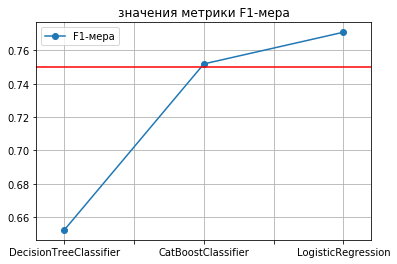

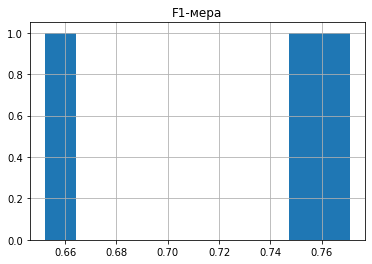

In [18]:
# создадим словарь, в который запишем значения метрики F1
# каждой модели
models_f1 = {'DecisionTreeClassifier': [result_1],
              'CatBoostClassifier': [result_3],
              'LogisticRegression': [result_5]}

# создадим датафрейм 
models_f1 = pd.DataFrame(models_f1, index=['F1-мера']).T

# построим графики показателей качества 
models_f1['F1-мера'].plot(style='o-', xlim=(-0.2, 2.2), 
                          legend=True, grid=True)

plt.axhline(y=0.75, color='r', linestyle='-')
plt.title('значения метрики F1-мера')
plt.show()

- пришли к выводу, что без использования BERT поставленной задачи удалось добиться при помощи логистической регрессии и CatBoost, модель решающее дерево не достигла показателя метрики F1 больше 0,75.

Таким образом для решения поставленной задачи лучше всего подходит логистическая регрессия, которая является наиболее стабильной (в плане значений целевой метрики) как на валидационной, так и на тестовой выборках, при этом значительно быстрее остальных моделей обучается. Также достигает целевых показателей модель CatBoost, но долго обучается.